Directory of the tests: `/BGFS/DISASTER/grimast/calibration3arcmin_workflow/catchments/4814/`

Experiments:
* `out_Gv5test5_deapup_MCT_TL_RES/long_term_run/`
* `out_Gv5test5_deapup_MCT_TL_RES/long_term_run_FIXreservoirsmodule/`
* `out_deapup_MCT_TL_RESmapspar0303205_RESfix_RFparam/long_term_run_RESFILL/`

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from lisflood_read_plot import *

from reservoirs_lshm.utils.plots import plot_resops, reservoir_analysis

## Config

In [25]:
PATH_TESTS = Path('Z:/nahaUsers/casadje/GloFASv5/reservoirs/tests')

catchment = '629'
# test = 'out_Gv5test5_deapup_MCT_TL_RES'
test_1 = 'DEAP'
test_2 = 'RF'
# test = 'out_deapup_MCT_TL_RESmapspar0303205_RESfix_RFparam/long_term_run_RESFILL_standardparam'
# PATH_RESULTS = PATH_TESTS / catchment / test

# PATH_OBS = Path('Z:/nahaUsers/casadje/datasets/Kazakhstan/reservoirs/timeseries/processed')

## Records

In [26]:
# observed = pd.read_csv(PATH_OBS / 'shardara.csv', parse_dates=True, index_col='date')
# observed.rename(columns={'inflow m3/sec': 'inflow', 'discharge m3/sec': 'outflow', 'volume million/m3': 'filling'}, inplace=True)
# observed.filling /= 6700 # 5200 hm3 according to Kazakhstan

# observed.head()

## Model

### Time series

In [27]:
# files to be read
tss_files = {
    'resfill': 'filling',
    'qresin': 'inflow',
    'qresout': 'outflow',
}

# find settings file
try:
    settings_file = list(PATH_RESULTS.glob('*.xml'))[0]
except:
    settings_file = None

In [28]:
# read results
results_RF = {}
for file, variable in tss_files.items():
    df = read_tss(
        tss=PATH_TESTS / catchment / 'RF' / f'{file}.tss',
        xml=settings_file
    )
    df = df.replace(1e31, np.nan).dropna(axis=1, how='all')
    df.columns = df.columns.astype(int)
    results_RF[variable] = df

# reorganize results
results_RF = {
    ID: pd.concat([df[ID] for df in results_RF.values()], axis=1, keys=results_RF.keys())
    for ID in results_RF[list(results_RF)[0]].columns
}

In [29]:
# read results
results_DEAP = {}
for file, variable in tss_files.items():
    df = read_tss(
        tss=PATH_TESTS / catchment / 'DEAP' / f'{file}.tss',
        xml=settings_file
    )
    df = df.replace(1e31, np.nan).dropna(axis=1, how='all')
    df.columns = df.columns.astype(int)
    results_DEAP[variable] = df

# reorganize results
results_DEAP = {
    ID: pd.concat([df[ID] for df in results_DEAP.values()], axis=1, keys=results_DEAP.keys())
    for ID in results_DEAP[list(results_DEAP)[0]].columns
}

### Reservoir attributes

In [30]:
attributes = []
for txt_file in (PATH_TESTS  / 'tables' / 'new').glob('reservoirs*20250228.txt'):
    print(txt_file)
    attr = pd.read_csv(txt_file, sep='\t', header=None, index_col=0)
    attr.columns = ['_'.join(txt_file.stem.split('_')[2:-1])]
    attr.index.name = 'ID'
    attributes.append(attr)
attributes = pd.concat(attributes, axis=1)
attributes = attributes.loc[results_RF.keys()]

attributes.head()

Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_100yr_inflow_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_avg_inflow_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_capacity_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_env_flow_20250228.txt


,100yr_inflow,avg_inflow,capacity,env_flow
ID,,,,
287,966.8,168.5,19500000000,8.423
288,3387.7,849.7,6700000000,42.483
292,2779.9,673.2,4160000000,33.660
1449,668.8,88.3,2000000000,4.414
1468,115.3,15.2,250000000,0.760


### Reservoir parameters

In [31]:
parameters = []
for txt_file in (PATH_TESTS  / 'parameters').glob('reservoirs*.txt'):
    print(txt_file)
    par = pd.read_csv(txt_file, sep='\t', header=None, index_col=0)
    par.columns = ['_'.join(txt_file.stem.split('_')[2:])]
    par.index.name = 'ID'
    parameters.append(par)
parameters = pd.concat(parameters, axis=1)
parameters = parameters.loc[results_RF.keys()]

# parameters = pd.DataFrame(index=attributes.index)
# parameters['flood_storage'] = 0.75
# parameters['outflow_factor'] = 0.3

parameters.head()

Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\parameters\reservoirs_glofas5_flood_storage.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\parameters\reservoirs_glofas5_outflow_factor.txt


,flood_storage,outflow_factor
ID,,
287,0.527269,0.212829
288,0.633158,0.242280
292,0.628182,0.209229
1449,0.700348,0.209330
1468,0.782419,0.265217


### Reservoir limits

In [32]:
limits = pd.DataFrame(index=attributes.index, dtype=float)

limits['Vt'] = 1 # attributes.capacity
limits['Ve'] = 0.8 * limits.Vt + 0.2 * parameters.flood_storage
limits['Vf'] = parameters.flood_storage * limits.Vt
limits['Vc'] = 0.5 * limits.Vf

limits['Qf'] = parameters.outflow_factor *  attributes['100yr_inflow']
limits['Qn'] = attributes.avg_inflow
limits['Qc'] = limits.Qn * limits.Vc / limits.Vf
limits['Qmin'] = attributes.env_flow

limits.head()

,Vt,Ve,Vf,Vc,Qf,Qn,Qc,Qmin
ID,,,,,,,,
287,1,0.905454,0.527269,0.263634,205.763077,168.5,84.25,8.423
288,1,0.926632,0.633158,0.316579,820.771956,849.7,424.85,42.483
292,1,0.925636,0.628182,0.314091,581.635697,673.2,336.60,33.660
1449,1,0.940070,0.700348,0.350174,139.999904,88.3,44.15,4.414
1468,1,0.956484,0.782419,0.391209,30.579520,15.2,7.60,0.760


### Analysis

WindowsPath('Z:/nahaUsers/casadje/GloFASv5/reservoirs/tests/629/4161_RF_vs_DEAP.jpg')

In [40]:
for ID in results_RF:

    # plot_reservoir(
    #     sim2,
    #     title=ID
    # )
    reservoir_analysis(
        sim=results_DEAP[ID].iloc[1464:,:],
        obs=results_RF[ID].iloc[1464:,:],
        x1='filling',
        # x_thr=limits.loc[ID, ['Ve', 'Vf', 'Vf', 'Vc']],
        x2='inflow',
        y='outflow',
        # y_thr=limits.loc[ID, ['Qf', 'Qf', 'Qn', 'Qc']],
        title=ID,
        alpha=.5,
        save=PATH_TESTS / catchment / f'{ID}_RF_vs_DEAP.jpg'
    )

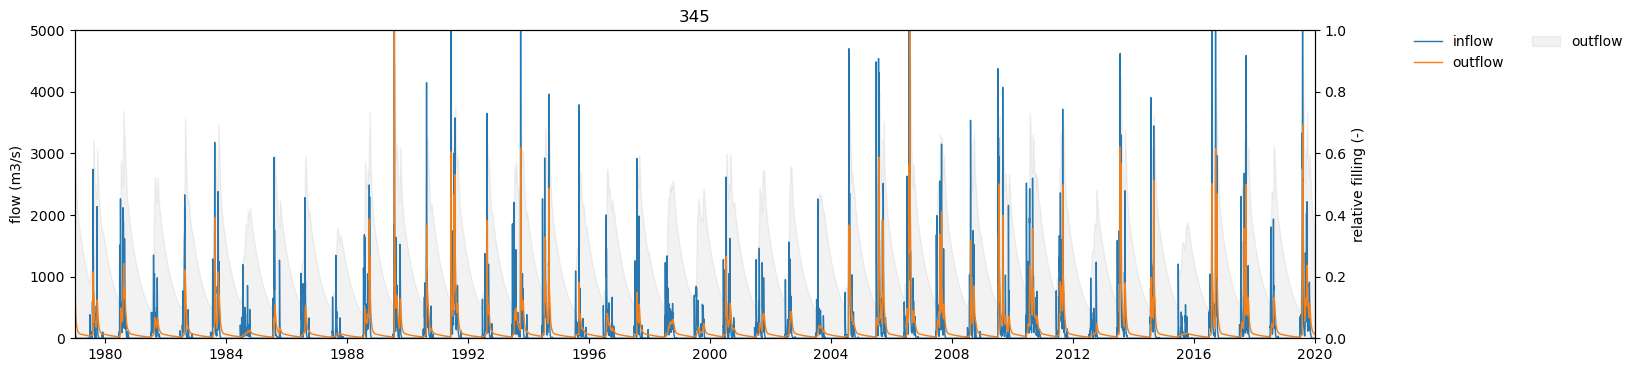

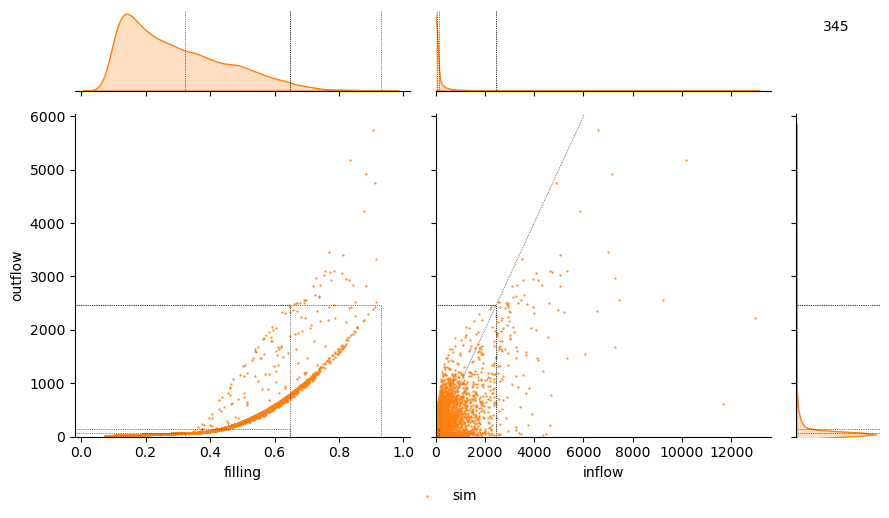

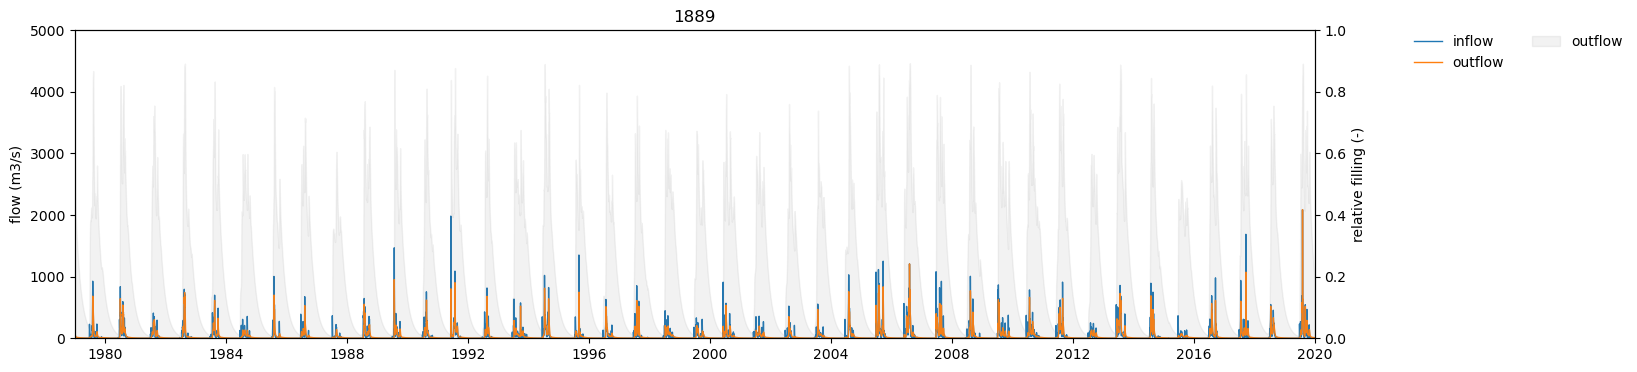

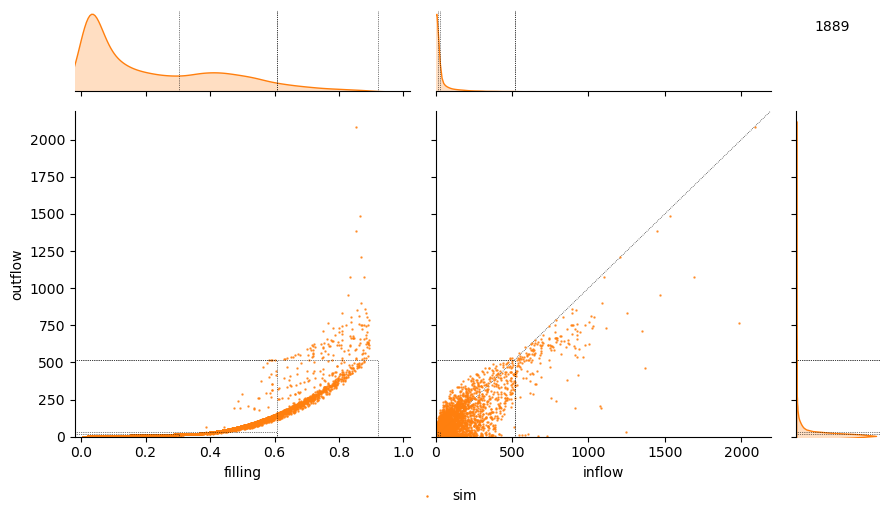

In [29]:
for ID, sim in results.items():
    plot_reservoir(sim, title=ID)
    if ID == 525:
        obs = observed
    else:
        obs = None
    reservoir_analysis(
        sim=sim,
        obs=obs,
        x1='filling',
        x_thr=limits.loc[ID, ['Ve', 'Vf', 'Vf', 'Vc']],
        x2='inflow',
        y='outflow',
        y_thr=limits.loc[ID, ['Qf', 'Qf', 'Qn', 'Qc']],
        title=ID,
        alpha=.8
    )

In [12]:
ID = 345
results[ID].inflow.min(), results[ID].outflow.min(), limits.loc[ID, 'Qmin']

(2.52051e-09, 8.43039, 6.769)